# dim16lr005FFF

In [1]:
#ライブラリインポート
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression

#標準化用
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import pandas as pd

#import scipy.stats as sp

import pickle
import numpy

import joblib

import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm

# ライブラリ

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from sklearn.metrics.cluster import adjusted_rand_score
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import numpy as np
from scipy.spatial.distance import euclidean, cdist
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csgraph


def DBCV(X, labels, dist_function=euclidean):
    """
    Density Based clustering validation
    Args:
        X (np.ndarray): ndarray with dimensions [n_samples, n_features]
            data to check validity of clustering
        labels (np.array): clustering assignments for data X
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point
    Returns: cluster_validity (float)
        score in range[-1, 1] indicating validity of clustering assignments
    """
    graph = _mutual_reach_dist_graph(X, labels, dist_function)
    mst = _mutual_reach_dist_MST(graph)
    cluster_validity = _clustering_validity_index(mst, labels)
    return cluster_validity


def _core_dist(point, neighbors, dist_function):
    """
    Computes the core distance of a point.
    Core distance is the inverse density of an object.
    Args:
        point (np.array): array of dimensions (n_features,)
            point to compute core distance of
        neighbors (np.ndarray): array of dimensions (n_neighbors, n_features):
            array of all other points in object class
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point
    Returns: core_dist (float)
        inverse density of point
    """
    n_features = np.shape(point)[0]
    n_neighbors = np.shape(neighbors)[0]

    distance_vector = cdist(point.reshape(1, -1), neighbors)
    distance_vector = distance_vector[distance_vector != 0]
    numerator = ((1/distance_vector)**n_features).sum()
    core_dist = (numerator / (n_neighbors - 1)) ** (-1/n_features)
    return core_dist


def _mutual_reachability_dist(point_i, point_j, neighbors_i,
                              neighbors_j, dist_function):
    """.
    Computes the mutual reachability distance between points
    Args:
        point_i (np.array): array of dimensions (n_features,)
            point i to compare to point j
        point_j (np.array): array of dimensions (n_features,)
            point i to compare to point i
        neighbors_i (np.ndarray): array of dims (n_neighbors, n_features):
            array of all other points in object class of point i
        neighbors_j (np.ndarray): array of dims (n_neighbors, n_features):
            array of all other points in object class of point j
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point
    Returns: mutual_reachability (float)
        mutual reachability between points i and j
    """
    core_dist_i = _core_dist(point_i, neighbors_i, dist_function)
    core_dist_j = _core_dist(point_j, neighbors_j, dist_function)
    dist = dist_function(point_i, point_j)
    mutual_reachability = np.max([core_dist_i, core_dist_j, dist])
    return mutual_reachability


def _mutual_reach_dist_graph(X, labels, dist_function):
    """
    Computes the mutual reach distance complete graph.
    Graph of all pair-wise mutual reachability distances between points
    Args:
        X (np.ndarray): ndarray with dimensions [n_samples, n_features]
            data to check validity of clustering
        labels (np.array): clustering assignments for data X
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point
    Returns: graph (np.ndarray)
        array of dimensions (n_samples, n_samples)
        Graph of all pair-wise mutual reachability distances between points.
    """
    n_samples = np.shape(X)[0]
    graph = []
    counter = 0
    for row in range(n_samples):
        graph_row = []
        for col in range(n_samples):
            point_i = X[row]
            point_j = X[col]
            class_i = labels[row]
            class_j = labels[col]
            members_i = _get_label_members(X, labels, class_i)
            members_j = _get_label_members(X, labels, class_j)
            dist = _mutual_reachability_dist(point_i, point_j,
                                             members_i, members_j,
                                             dist_function)
            graph_row.append(dist)
        counter += 1
        graph.append(graph_row)
    graph = np.array(graph)
    return graph


def _mutual_reach_dist_MST(dist_tree):
    """
    Computes minimum spanning tree of the mutual reach distance complete graph
    Args:
        dist_tree (np.ndarray): array of dimensions (n_samples, n_samples)
            Graph of all pair-wise mutual reachability distances
            between points.
    Returns: minimum_spanning_tree (np.ndarray)
        array of dimensions (n_samples, n_samples)
        minimum spanning tree of all pair-wise mutual reachability
            distances between points.
    """
    mst = minimum_spanning_tree(dist_tree).toarray()
    return mst + np.transpose(mst)


def _cluster_density_sparseness(MST, labels, cluster):
    """
    Computes the cluster density sparseness, the minimum density
        within a cluster
    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
        cluster (int): cluster of interest
    Returns: cluster_density_sparseness (float)
        value corresponding to the minimum density within a cluster
    """
    indices = np.where(labels == cluster)[0]
    cluster_MST = MST[indices][:, indices]
    cluster_density_sparseness = np.max(cluster_MST)
    return cluster_density_sparseness


def _cluster_density_separation(MST, labels, cluster_i, cluster_j):
    """
    Computes the density separation between two clusters, the maximum
        density between clusters.
    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
        cluster_i (int): cluster i of interest
        cluster_j (int): cluster j of interest
    Returns: density_separation (float):
        value corresponding to the maximum density between clusters
    """
    indices_i = np.where(labels == cluster_i)[0]
    indices_j = np.where(labels == cluster_j)[0]
    shortest_paths = csgraph.dijkstra(MST, indices=indices_i)
    relevant_paths = shortest_paths[:, indices_j]
    density_separation = np.min(relevant_paths)
    return density_separation


def _cluster_validity_index(MST, labels, cluster):
    """
    Computes the validity of a cluster (validity of assignmnets)
    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
        cluster (int): cluster of interest
    Returns: cluster_validity (float)
        value corresponding to the validity of cluster assignments
    """
    min_density_separation = np.inf
    for cluster_j in np.unique(labels):
        if cluster_j != cluster:
            cluster_density_separation = _cluster_density_separation(MST,
                                                                     labels,
                                                                     cluster,
                                                                     cluster_j)
            if cluster_density_separation < min_density_separation:
                min_density_separation = cluster_density_separation
    cluster_density_sparseness = _cluster_density_sparseness(MST,
                                                             labels,
                                                             cluster)
    numerator = min_density_separation - cluster_density_sparseness
    denominator = np.max([min_density_separation, cluster_density_sparseness])
    cluster_validity = numerator / denominator
    return cluster_validity


def _clustering_validity_index(MST, labels):
    """
    Computes the validity of all clustering assignments for a
    clustering algorithm
    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
    Returns: validity_index (float):
        score in range[-1, 1] indicating validity of clustering assignments
    """
    n_samples = len(labels)
    validity_index = 0
    for label in np.unique(labels):
        fraction = np.sum(labels == label) / float(n_samples)
        cluster_validity = _cluster_validity_index(MST, labels, label)
        validity_index += fraction * cluster_validity
    return validity_index


def _get_label_members(X, labels, cluster):
    """
    Helper function to get samples of a specified cluster.
    Args:
        X (np.ndarray): ndarray with dimensions [n_samples, n_features]
            data to check validity of clustering
        labels (np.array): clustering assignments for data X
        cluster (int): cluster of interest
    Returns: members (np.ndarray)
        array of dimensions (n_samples, n_features) of samples of the
        specified cluster.
    """
    indices = np.where(labels == cluster)[0]
    members = X[indices]
    return members

c_c_death_PT_ID = numpy.load('all_cancer/data/c_c_death_PT_ID.npy')
c_c_death_PT_ID = list(c_c_death_PT_ID)#4674人

c_c_PT_ID = numpy.load('all_cancer/data/c_c_list_PT_ID.npy')
c_c_PT_ID = list(c_c_PT_ID)#10863

print("#number of patients:",len(c_c_PT_ID))

death_pt = []
not_death_pt = []
for i in range(len(c_c_PT_ID)):
    one_c_c_PT_ID = c_c_PT_ID[i]
    if one_c_c_PT_ID in c_c_death_PT_ID:
        death_pt.append(i)
    else:
        not_death_pt.append(i)
        
#stepsも読み込み
import numpy
all_data_steps = numpy.load('pt_id/data/c_c_timesteps.npy')
all_data_steps[0]

#dim
#,lr=0.005
#ttt
#の潜在状態空間の点（ヒートマップのデータ）を読み込み
#["z_params"][0]=>平均：データ数　x タイムステップ x 状態空間次元
obj_dim2=joblib.load("pt_id/model/result_save_ds/notage_dim16/notage_dim16_lr005_FFF/test.jbl")
x_dim2 = obj_dim2["z_params"][0]

df_x_dim2 = []
#c_c_PT_ID -> c_c_death_PT_ID
for i in range(len(c_c_PT_ID)):
    x_dim2_one = x_dim2[i]
    x_dim2_one = pd.DataFrame(x_dim2_one)
    all_data_steps_one = all_data_steps[i]
    x_dim2_one = x_dim2_one.head(all_data_steps_one)
    x_dim2_one['pt_no'] = i
    # i -> death_pt[i]
    df_x_dim2.append(x_dim2_one)
print(df_x_dim2[0])

concat_df_x_dim2 = pd.concat(df_x_dim2)
concat_df_x_dim2 = concat_df_x_dim2.reset_index(drop=True)

list_pt_no = concat_df_x_dim2['pt_no']
df_pt_no = pd.DataFrame(list_pt_no)

concat_df_x_dim2 = concat_df_x_dim2.drop(['pt_no'], axis = 1)


concat_df_x_dim2

#number of patients: 10863
            0         1         2         3         4         5         6  \
0   -0.184232 -0.636557  0.016608  1.074124  0.227896 -0.174968  0.726564   
1    0.371580 -0.061416  0.131887  0.661644 -0.053251 -0.017134  0.152439   
2    0.402836 -0.018489  0.164082  0.662381 -0.058986  0.011598  0.119048   
3    0.388032 -0.011279  0.170154  0.662057 -0.070020  0.017298  0.113940   
4    0.384110 -0.009180  0.168537  0.661003 -0.073221  0.018893  0.113549   
..        ...       ...       ...       ...       ...       ...       ...   
123  0.425074 -0.102463  0.038632  0.700169  0.033277 -0.051360  0.198210   
124  0.405126 -0.109949  0.031923  0.697231  0.023410 -0.054970  0.198189   
125  0.400885 -0.119894  0.031972  0.704817  0.029687 -0.064165  0.204399   
126  0.382436 -0.121854  0.028487  0.699905  0.016614 -0.062391  0.201773   
127  0.401211 -0.076299  0.051684  0.677197 -0.013305 -0.029881  0.171385   

            7         8         9        10     

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.184232,-0.636557,0.016608,1.074124,0.227896,-0.174968,0.726564,-2.059780,-0.285596,1.250517,-1.584839,0.145761,0.552062,-0.066133,0.723960,-0.770008
1,0.371580,-0.061416,0.131887,0.661644,-0.053251,-0.017134,0.152439,-2.039532,-0.452380,1.799489,-1.227181,-0.018420,0.202725,-0.028983,0.905949,0.018823
2,0.402836,-0.018489,0.164082,0.662381,-0.058986,0.011598,0.119048,-2.006558,-0.383978,1.831354,-1.257014,-0.014247,0.197634,0.000007,0.956791,0.097522
3,0.388032,-0.011279,0.170154,0.662057,-0.070020,0.017298,0.113940,-1.999770,-0.372083,1.831994,-1.256360,0.000798,0.211295,0.006779,0.935943,0.075295
4,0.384110,-0.009180,0.168537,0.661003,-0.073221,0.018893,0.113549,-2.006088,-0.371947,1.834296,-1.255730,0.005612,0.215793,0.004812,0.926773,0.062412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562897,0.401154,-0.020129,0.136785,0.660571,-0.049785,0.013635,0.131875,-2.144812,-0.437062,1.881476,-1.266061,-0.015157,0.215603,-0.038502,0.921637,0.025045
1562898,0.430074,-0.008993,0.162877,0.678875,-0.025664,0.001138,0.122899,-1.959792,-0.380849,1.835172,-1.269732,-0.024324,0.183231,0.017469,1.024524,0.210479
1562899,0.394229,0.005305,0.190302,0.667616,-0.059991,0.014972,0.103749,-1.847626,-0.312254,1.798594,-1.254445,0.022496,0.200279,0.054277,0.975953,0.162497
1562900,0.370793,0.017391,0.222170,0.658548,-0.089791,0.027717,0.087556,-1.696596,-0.235445,1.752140,-1.237369,0.064618,0.205573,0.089158,0.944027,0.140513


In [2]:
print("#number of patients:",len(c_c_PT_ID))

#number of patients: 10863


In [3]:
#list_range_eps = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
label = []
list_range_eps = [0.001]

for range_eps_i in range(len(list_range_eps)):
    label_one = numpy.load('py_cc_notage_dim16_lr01_dbscan_label_min5_' + str(range_eps_i) + '.npy')
# DBSCANクラスタ
    print(list_range_eps[range_eps_i])
    label.append(label_one)

0.001


# PCA

In [4]:
#主成分分析で2次元にしてみる 
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)

pca.fit(concat_df_x_dim2)
pca_x_dim2 = pca.transform(concat_df_x_dim2)

pca_x_dim2 = pd.DataFrame(pca_x_dim2)
#pca_x_dim2.to_csv('pt_id/fig_save/notage_dim16_lr005_FFF/pca.csv')

#解体作業 
pca_x_dim2 = pd.concat([pca_x_dim2, df_pt_no], axis = 1, join = 'inner') 
pca_x_dim2 
pca_dim2 = []
for x in range(len(c_c_PT_ID)): 
#for x in not_death_pt:
    pca_i_dim2 = pca_x_dim2[pca_x_dim2['pt_no'] == x] 
    pca_i_dim2 = pca_i_dim2.drop(['pt_no'], axis = 1) 
    pca_dim2.append(pca_i_dim2)
pca_dim2[0]

,0,1
0,-0.587490,1.539808
1,-0.709124,0.018494
2,-0.655233,-0.074222
3,-0.631539,-0.057814
4,-0.633658,-0.048387
...,...,...
123,-1.058918,0.110157
124,-1.037348,0.164498
125,-0.970986,0.177542
126,-0.961931,0.226249


In [5]:
len(pca_x_dim2)

1562902

In [6]:
plt.figure(figsize=(10, 10))

for p in not_death_pt:
    x_dim2 = pca_dim2[p]
    x = x_dim2[0]
    y = x_dim2[1]
    z_1 = x.tail(1)
    z_2 = y.tail(1)

    plt.plot(x, y, color = 'steelblue',lw = 0.02)
    #plt.scatter(x, y, color = 'b', s = 1)
    plt.scatter(z_1, z_2, color = 'steelblue', s = 20)
    #plotにお名前つける
    #plt.annotate(p, (z_1,z_2))

for p in death_pt:
    x_dim2 = pca_dim2[p]
    x = x_dim2[0]
    y = x_dim2[1]
    z_1 = x.tail(1)
    z_2 = y.tail(1)

    plt.plot(x, y, color = 'indianred',lw = 0.02)
    #plt.scatter(x, y, color = 'r', s = 1)
    plt.scatter(z_1, z_2, color = 'indianred', s = 20)
    #plotにお名前つける
    #plt.annotate(p, (z_1,z_2))
#plt.axes().set_aspect('equal')
plt.xticks(color="None")
plt.yticks(color="None")
plt.grid(True)

plt.figure(figsize=(10, 10))
plt.savefig('py_notage_dim16_lr005_FFF_pca0.png')

plt.figure(figsize=(10, 10))
for p in not_death_pt:
    x_dim2 = pca_dim2[p]
    x = x_dim2[0]
    y = x_dim2[1]
    z_1 = x.tail(1)
    z_2 = y.tail(1)

    #plt.plot(x, y, color = 'b',lw = 0.01)
    #plt.scatter(x, y, color = 'b', s = 1)
    plt.scatter(z_1, z_2, color = 'steelblue', s = 20)
    #plotにお名前つける
    #plt.annotate(p, (z_1,z_2))

for p in death_pt:
    x_dim2 = pca_dim2[p]
    x = x_dim2[0]
    y = x_dim2[1]
    z_1 = x.tail(1)
    z_2 = y.tail(1)

    #plt.plot(x, y, color = 'r',lw = 0.01)
    #plt.scatter(x, y, color = 'r', s = 1)
    plt.scatter(z_1, z_2, color = 'indianred', s = 20)
    #plotにお名前つける
    #plt.annotate(p, (z_1,z_2))
#plt.axes().set_aspect('equal')
plt.xticks(color="None")
plt.yticks(color="None")
plt.grid(True)
plt.savefig('py_notage_dim16_lr005_FFF_pca1.png')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff60ed57550> (for post_execute):


KeyboardInterrupt: 

In [ ]:
pca_x_dim2

In [ ]:
len(label[0])

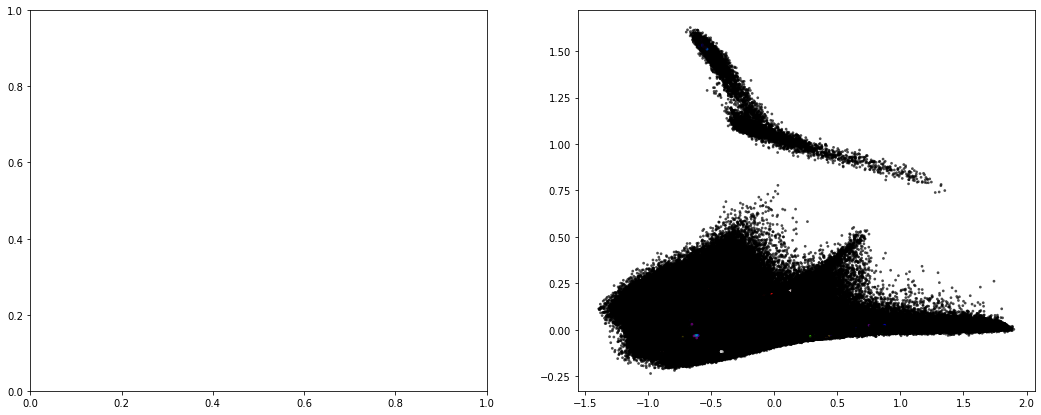

In [7]:
X = pca_x_dim2

range_eps = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
    
#クラスタ図の作成

#2nd Plot showing the actual clusters formed
cluster_labels = label[range_eps]
n_clusters = len(np.unique(cluster_labels))
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[0], X[1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    #ax2.scatter(clusterer[:, 0], clusterer[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
        

plt.show()

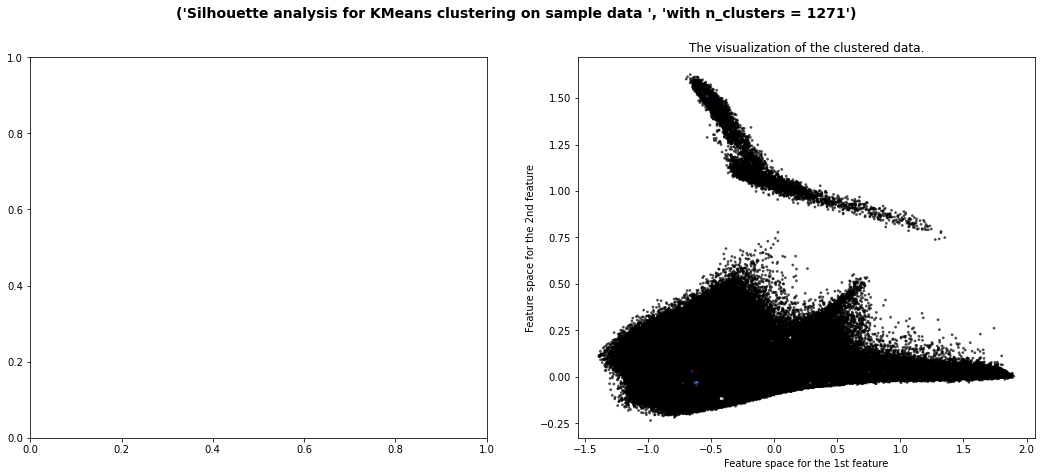

In [8]:
X = pca_x_dim2

for range_eps in range(len(list_range_eps)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
#クラスタ図の作成

#2nd Plot showing the actual clusters formed
    cluster_labels = label[range_eps]
    n_clusters = len(np.unique(cluster_labels))
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[0], X[1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    #ax2.scatter(clusterer[:, 0], clusterer[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
        
    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')
    plt.suptitle(('Silhouette analysis for KMeans clustering on sample data ', 'with n_clusters = %d' % n_clusters), fontsize=14, fontweight='bold')

plt.show()